In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [2]:
file_path = r'merged_dataset_reduced(15_files).h5'

with h5py.File(file_path, "r") as f:
    print("Top-level datasets:", list(f.keys()))
    
    radar_data = f['radar_data'][:]
    print("Shape of radar_data:", radar_data.shape)
    print("Data type:", radar_data.dtype)

df1 = pd.DataFrame({name: radar_data[name] for name in radar_data.dtype.names})
#df=df1
df = df1[df1['label_id'] != 11].copy()

#We removed the 11th label, as it corresponds to the background (ie buildings, road ..) and as such was hugely imbalancing the set, while providing no value.

print(df.head())
print(df.info())


Top-level datasets: ['odometry', 'radar_data']
Shape of radar_data: (8348149,)
Data type: [('timestamp', '<i8'), ('sensor_id', 'u1'), ('range_sc', '<f4'), ('azimuth_sc', '<f4'), ('rcs', '<f4'), ('vr', '<f4'), ('vr_compensated', '<f4'), ('x_cc', '<f4'), ('y_cc', '<f4'), ('x_seq', '<f4'), ('y_seq', '<f4'), ('uuid', 'S32'), ('track_id', 'S32'), ('label_id', 'u1')]
        timestamp  sensor_id   range_sc  azimuth_sc        rcs         vr  \
98   156862659751          2  38.054634    0.449997  26.412235  -0.088121   
99   156862659751          2  39.912693    0.443244  -7.088804  -0.101021   
232  156862701077          3  38.075844   -0.452232  25.624640  -0.108044   
233  156862701077          3  39.398964   -0.446695   2.582060  -0.095119   
289  156862701077          3  37.103336   -0.283018 -11.385833 -11.708483   

     vr_compensated       x_cc      y_cc       x_seq       y_seq  \
98         9.982620  41.911007 -0.174438 -204.212921 -248.272385   
99         9.970025  43.771698 -0.418

Number of rows: 296416
Number of columns: 14

Missing values per column:
timestamp         0
sensor_id         0
range_sc          0
azimuth_sc        0
rcs               0
vr                0
vr_compensated    0
x_cc              0
y_cc              0
x_seq             0
y_seq             0
uuid              0
track_id          0
label_id          0
dtype: int64

Unique labels: [ 0  7  2 10  1  5  8  4  3  6]
Label distribution:
label_id
0     205865
2      31688
7      16867
8      14526
3      10443
10      6797
1       5856
4       2340
5       1752
6        282
Name: count, dtype: int64


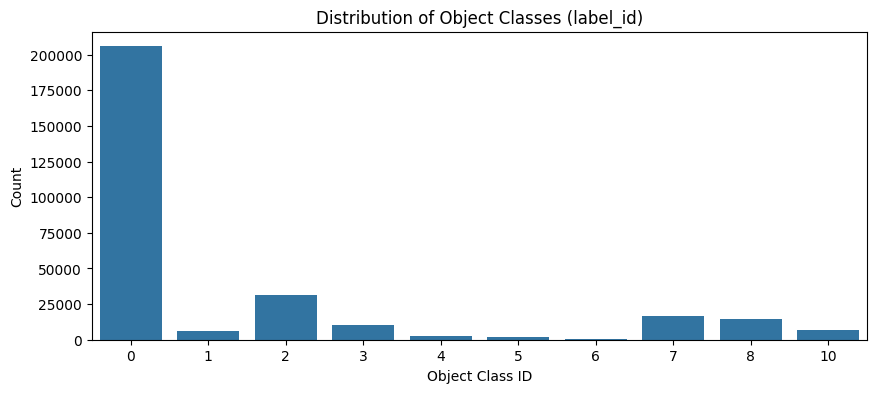

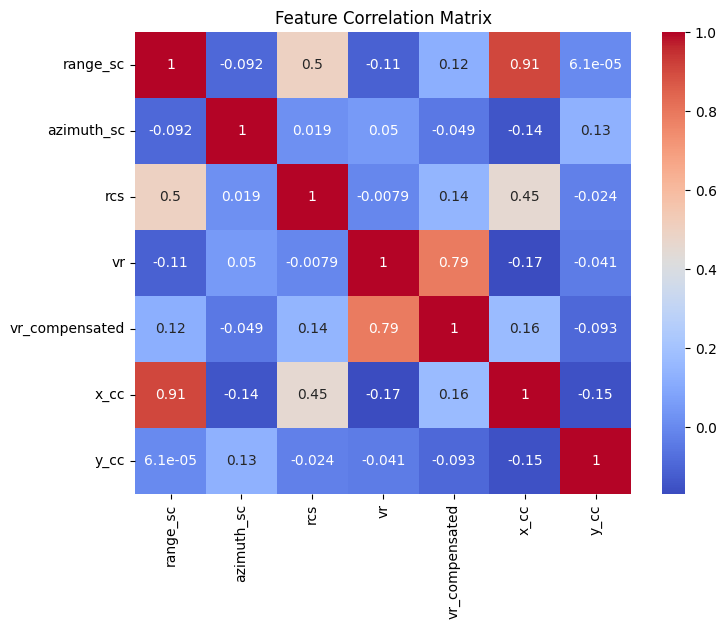

In [3]:
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nUnique labels:", df['label_id'].unique())
print("Label distribution:")
print(df['label_id'].value_counts())

#We want to visualize the imbalance in the different labels present in this file

plt.figure(figsize=(10,4))
sns.countplot(x='label_id', data=df)
plt.title('Distribution of Object Classes (label_id)')
plt.xlabel('Object Class ID')
plt.ylabel('Count')
plt.show()

#Same thing, but with a correlation matrix

num_features = ['range_sc', 'azimuth_sc', 'rcs', 'vr', 'vr_compensated', 'x_cc', 'y_cc']
corr = df[num_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
#We select the useful features

features = ['range_sc', 'azimuth_sc', 'rcs', 'vr', 'vr_compensated', 'x_cc', 'y_cc']
target = 'label_id'

X = df[features]
y = df[target]

df_clean = pd.concat([X, y], axis=1).dropna()

X = df_clean[features]
y = df_clean[target]
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Problem Formalization :

- Predict the object type (label_id) detected by a radar from its signal features.

- Type: Multi-class classification

- Input: Radar features (range_sc, azimuth_sc, rcs, vr, vr_compensated, x_cc, y_cc)

- Output: label_id as integers :
    passenger cars (0), 
    large vehicles (like agricultural or construction vehicles) (1), 
    trucks (2), 
    busses (3), 
    trains (4), 
    bicycles (5), 
    motorized two-wheeler (6), 
    pedestrians (7), 
    groups of pedestrian (8), 
    animals (9), 
    all other dynamic objects encountered while driving (10)

- Goal: Build a model that classifies radar detections accurately.

- Evaluation metrics: Accuracy, weighted F1-score, confusion matrix.



Accuracy: 0.702213076040753
Weighted F1 Score: 0.6014196226721891

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.98      0.82     41174
           1       0.77      0.13      0.22      1171
           2       0.48      0.06      0.11      6338
           3       0.32      0.01      0.02      2089
           4       0.00      0.00      0.00       468
           5       0.00      0.00      0.00       350
           6       0.00      0.00      0.00        56
           7       0.00      0.00      0.00      3374
           8       0.21      0.02      0.04      2905
           9       0.62      0.35      0.45      1359

    accuracy                           0.70     59284
   macro avg       0.31      0.16      0.17     59284
weighted avg       0.60      0.70      0.60     59284



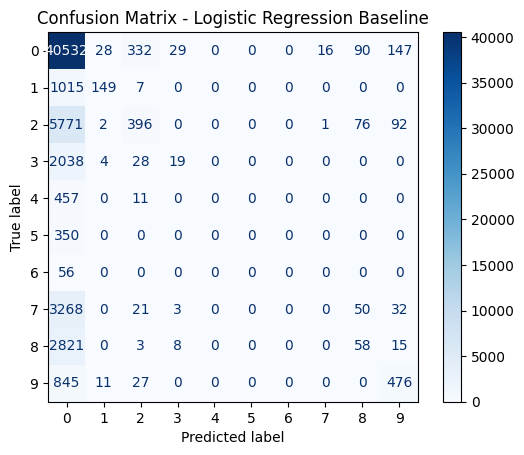

In [10]:
# We start simple : logistic regression. Ideas for improvements : RandomForest, imbalance management, deeplearning models

model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Weighted F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=np.sort(np.unique(y))).plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression Baseline")
plt.show()



In [15]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/124.9 MB 7.2 MB/s eta 0:00:18
   - -------------------------------------- 3.1/124.9 MB 8.8 MB/s eta 0:00:14
   - -------------------------------------- 4.2/124.9 MB 7.6 MB/s eta 0:00:16
   - -------------------------------------- 6.0/124.9 MB 7.5 MB/s eta 0:00:16
   -- ------------------------------------- 7.6/124.9 MB 7.6 MB/s eta 0:00:16
   -- ------------------------------------- 8.9/124.9 MB 7.3 MB/s eta 0:00:16
   --- ------------------------------------ 10.0/124.9 MB 7.1 MB/s eta 0:00:17
   --- ------------------------------------ 11.3/124.9 MB 6.8 MB/s eta 0:00:17
   ---- ----------------------------------- 12.6/124.9 MB 6.7 MB/s eta 0:00:17
   ---- ----------------------------------- 13.9/124.9 MB 6.7 MB/s eta 0:00:17
   ---- ----------------------------------- 15.2/124.9 MB 6.6 MB/s eta 0:00:17
   ----- ---------------------------------- 16.3/124.9 MB 6.5 MB/s

c:\Users\vplan\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [10:00:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Random Forest ---
Accuracy: 0.9490250320491195
Weighted F1 Score: 0.9479385620424748
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     41174
           1       0.93      0.77      0.84      1171
           2       0.96      0.86      0.90      6338
           3       0.96      0.84      0.90      2089
           4       0.91      0.87      0.89       468
           5       0.97      0.72      0.83       350
           6       0.94      0.88      0.91        56
           7       0.90      0.88      0.89      3374
           8       0.91      0.88      0.89      2905
           9       0.97      0.85      0.91      1359

    accuracy                           0.95     59284
   macro avg       0.94      0.85      0.89     59284
weighted avg       0.95      0.95      0.95     59284



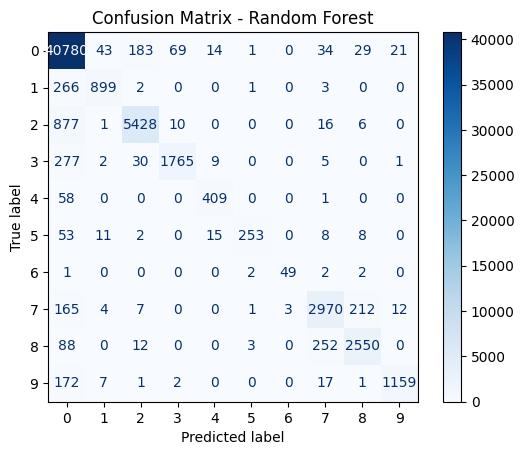

--- XGBoost ---
Accuracy: 0.9002597665474664
Weighted F1 Score: 0.896320340037266
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     41174
           1       0.89      0.60      0.72      1171
           2       0.89      0.69      0.78      6338
           3       0.90      0.77      0.83      2089
           4       0.88      0.81      0.84       468
           5       0.93      0.57      0.70       350
           6       0.86      0.86      0.86        56
           7       0.78      0.76      0.77      3374
           8       0.81      0.77      0.79      2905
           9       0.97      0.73      0.83      1359

    accuracy                           0.90     59284
   macro avg       0.88      0.75      0.81     59284
weighted avg       0.90      0.90      0.90     59284



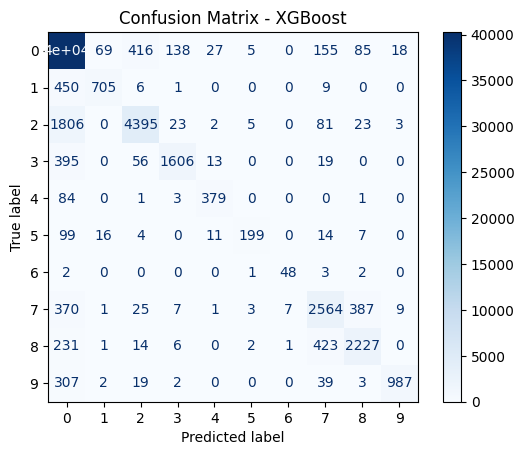

--- Ensemble Voting (RF + XGB) ---
Accuracy: 0.9350752310910195
Weighted F1 Score: 0.9331464981628703
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     41174
           1       0.93      0.71      0.81      1171
           2       0.95      0.81      0.87      6338
           3       0.95      0.81      0.87      2089
           4       0.90      0.85      0.87       468
           5       0.98      0.67      0.79       350
           6       0.87      0.86      0.86        56
           7       0.87      0.84      0.86      3374
           8       0.89      0.85      0.87      2905
           9       0.98      0.79      0.87      1359

    accuracy                           0.94     59284
   macro avg       0.93      0.82      0.86     59284
weighted avg       0.94      0.94      0.93     59284



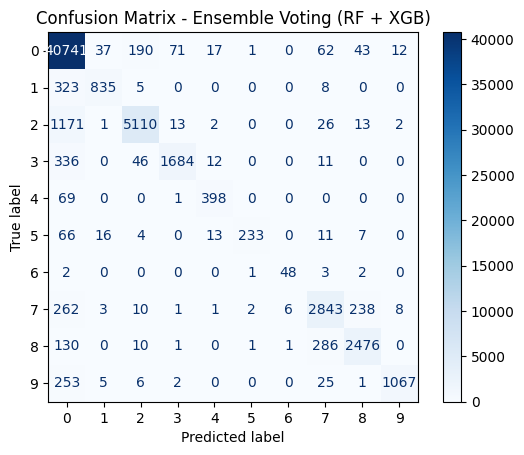

In [16]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

#We complexify a bit : we compare three other models, and observe that Random Forest seems to work best with this sample of data.


#Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

#XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

#Voting ensemble 
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft',
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
xgb.fit(X_train_scaled, y_train)
ensemble.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_ensemble = ensemble.predict(X_test_scaled)

def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Weighted F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print(classification_report(y_true, y_pred, zero_division=0))
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                           display_labels=np.sort(np.unique(y_true))).plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_ensemble, "Ensemble Voting (RF + XGB)")


Before resampling: 0    164691
2     25350
7     13493
8     11621
3      8354
9      5438
1      4685
4      1872
5      1402
6       226
Name: count, dtype: int64

After resampling: 5    164691
0    164691
1    164691
2    164691
7    164691
4    164691
8    164691
9    164691
3    164691
6    164691
Name: count, dtype: int64
LR Accuracy: 0.2514337763983537
LR F1: 0.31587471579584214

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.23      0.37     41174
           1       0.08      0.55      0.15      1171
           2       0.24      0.25      0.24      6338
           3       0.09      0.12      0.10      2089
           4       0.03      0.57      0.06       468
           5       0.01      0.18      0.03       350
           6       0.01      0.88      0.02        56
           7       0.09      0.06      0.07      3374
           8       0.14      0.48      0.22      2905
           9       0.29      0.62      0.40  

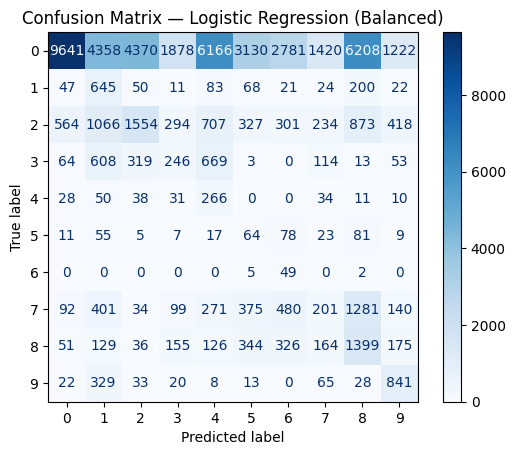

In [13]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Before resampling:", pd.Series(y_train).value_counts())
print("\nAfter resampling:", pd.Series(y_train_resampled).value_counts())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

logreg_balanced = LogisticRegression(max_iter=500, random_state=42)
logreg_balanced.fit(X_train_scaled, y_train_resampled)

y_pred_lr = logreg_balanced.predict(X_test_scaled)

print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print("LR F1:", f1_score(y_test, y_pred_lr, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))



ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lr),
                       display_labels=np.sort(np.unique(y))).plot(cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression (Balanced)")
plt.show()


